In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from math import sqrt
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms


In [2]:
SP=pd.read_csv('portfolio_equities.csv',delimiter=',',index_col='date')
SP_montly=pd.read_csv('portfolio_equities_monthly.csv',delimiter=',',index_col='date')
SP_montly

,PERMNO,TICKER,COMNAM,PRC
date,,,,
12/31/1986,10333,XOMA,XOMA CORP,11.875
01/30/1987,10333,XOMA,XOMA CORP,15.500
02/27/1987,10333,XOMA,XOMA CORP,20.250
03/31/1987,10333,XOMA,XOMA CORP,28.000
04/30/1987,10333,XOMA,XOMA CORP,28.500
05/29/1987,10333,XOMA,XOMA CORP,23.000
06/30/1987,10333,XOMA,XOMA CORP,20.000
07/31/1987,10333,XOMA,XOMA CORP,19.500
08/31/1987,10333,XOMA,XOMA CORP,21.500


In [3]:
def get_equities_data(SP,permno):
    matrix = SP.loc[lambda SP: SP['PERMNO'] == permno]
    return abs(matrix['PRC'])

SP.dropna(inplace=True)
SP_montly.dropna(inplace=True)

permnos = SP_montly.drop_duplicates('PERMNO')
permnos = permnos['PERMNO'].values
tickers = SP_montly.drop_duplicates('TICKER')
tickers = tickers['TICKER'].values
    
print(permnos)
print(tickers)

[10333 12490 14593 17778 43449 48725 55976]
['XOMA' 'IBM' 'AAPL' 'BKHT' 'BRK' 'MCD' 'UNP' 'WMT']


In [4]:
matrix_daily = SP.loc[lambda SP: SP['PERMNO'] == permnos[0]]
index_daily = matrix_daily.index

matrix_monthly = SP_montly.loc[lambda SP_montly: SP_montly['PERMNO'] == permnos[0]]
index_monthly = matrix_monthly.index

columns = ['XOMA','IBM','AAPL','BRK','MCD','UNP','WMT']

df_daily = pd.DataFrame(index=index_daily, columns=columns)
df_daily = df_daily.fillna(0)

df_monthly = pd.DataFrame(index=index_monthly, columns=columns)
df_monthly = df_monthly.fillna(0)

def equity_to_df(SP, perm, df, columns):
    for i in range(len(columns)):
        df[columns[i]]= get_equities_data(SP, perm[i])
    return df

df_daily = equity_to_df(SP, permnos,df_daily ,columns)
"""
df_daily['XOMA'] = get_equities_data(SP,permnos[0])
df_daily['IBM'] = get_equities_data(SP,permnos[1])
df_daily['AAPL'] = get_equities_data(SP,permnos[2])
df_daily['BRK'] = get_equities_data(SP,permnos[3])
df_daily['MCD'] = get_equities_data(SP,permnos[4])
df_daily['UNP'] = get_equities_data(SP,permnos[5])
df_daily['WMT'] = get_equities_data(SP,permnos[6])
"""
df_monthly = equity_to_df(SP_montly, permnos, df_monthly, columns)
"""
df_monthly['XOMA'] = get_equities_data(SP_montly,permnos[0])
df_monthly['IBM'] = get_equities_data(SP_montly,permnos[1])
df_monthly['AAPL'] = get_equities_data(SP_montly,permnos[2])
df_monthly['BRK'] = get_equities_data(SP_montly,permnos[3])
df_monthly['MCD'] = get_equities_data(SP_montly,permnos[4])
df_monthly['UNP'] = get_equities_data(SP_montly,permnos[5])
df_monthly['WMT'] = get_equities_data(SP_montly,permnos[6])
"""
df_monthly

,XOMA,IBM,AAPL,BRK,MCD,UNP,WMT
date,,,,,,,
12/31/1986,11.8750,120.00000,40.50000,2820.00000,60.875,62.25000,46.500
01/30/1987,15.5000,128.75000,55.50000,3100.00000,69.750,68.50000,48.500
02/27/1987,20.2500,139.50000,70.00000,3360.00000,76.250,72.62500,54.750
03/31/1987,28.0000,150.12500,64.50000,3520.00000,79.250,75.00000,57.500
04/30/1987,28.5000,160.12500,79.25000,3380.00000,80.000,71.37500,56.625
05/29/1987,23.0000,160.00000,79.00000,3410.00000,78.750,70.75000,58.500
06/30/1987,20.0000,162.50000,40.50000,3500.00000,53.000,78.37500,67.625
07/31/1987,19.5000,161.00000,41.25000,3960.00000,55.500,84.75000,37.250
08/31/1987,21.5000,168.37500,54.00000,3990.00000,58.250,79.75000,40.500


In [5]:
ret_daily= df_daily.pct_change(1)
ret_daily = ret_daily.drop(ret_daily.index[[0]])

ret_monthly= df_monthly.pct_change(1)
ret_monthly = ret_monthly.drop(ret_monthly.index[[0]])

ret_monthly

,XOMA,IBM,AAPL,BRK,MCD,UNP,WMT
date,,,,,,,
01/30/1987,0.305263,0.072917,0.370370,0.099291,0.145791,0.100402,0.043011
02/27/1987,0.306452,0.083495,0.261261,0.083871,0.093190,0.060219,0.128866
03/31/1987,0.382716,0.076165,-0.078571,0.047619,0.039344,0.032702,0.050228
04/30/1987,0.017857,0.066611,0.228682,-0.039773,0.009464,-0.048333,-0.015217
05/29/1987,-0.192982,-0.000781,-0.003155,0.008876,-0.015625,-0.008757,0.033113
06/30/1987,-0.130435,0.015625,-0.487342,0.026393,-0.326984,0.107774,0.155983
07/31/1987,-0.025000,-0.009231,0.018519,0.131429,0.047170,0.081340,-0.449168
08/31/1987,0.102564,0.045807,0.309091,0.007576,0.049550,-0.058997,0.087248
09/30/1987,-0.127907,-0.104677,0.046296,0.057644,-0.072961,0.004702,-0.064815


In [6]:

#This code loads the totalReturns.csv file, 
#which has the dates in the first column,
#the data (in index level) for the four asset classes in columns 2 to 5
#and the risk-free rate (1-month T-bill rate) in column 6. 
S=pd.read_csv('totalReturns.csv',delimiter=',',index_col='Date')
S = S.drop('Unnamed: 6',1)

#compute returns
ret= S.pct_change(1) #take one month before in order to be able to calculate the first return
ret = ret.drop('1M T-bill rate',1)
Rf = S.iloc[:,-1].shift(1)/12 
Rf = Rf.drop(Rf.index[[0]])
ret = ret.drop(ret.index[[0]])


Rf = Rf.drop(Rf.index[range(12*9)])
print(Rf)

#compute portfolio weights
roll_monthly_mean = ret_monthly.rolling(window=120,min_periods=120).mean() #rolling window = 12 month * 10 years of data to define returns of each portfolios
roll_monthly_std = ret_monthly.rolling(window=120,min_periods=120).std()
roll_monthly_cov = ret_monthly.rolling(window=120,min_periods=120).cov()
roll_Rf = Rf.rolling(window=120,min_periods=120).mean()

print(roll_monthly_mean)

Date
1/31/1987     0.004525
2/28/1987     0.004658
3/31/1987     0.004658
4/30/1987     0.004700
5/31/1987     0.004717
6/30/1987     0.004725
7/31/1987     0.004742
8/31/1987     0.005033
9/30/1987     0.005333
10/31/1987    0.005108
11/30/1987    0.004742
12/31/1987    0.004808
1/31/1988     0.004842
2/29/1988     0.004717
3/31/1988     0.004750
4/30/1988     0.004925
5/31/1988     0.005217
6/30/1988     0.005383
7/31/1988     0.005608
8/31/1988     0.005883
9/30/1988     0.006033
10/31/1988    0.006125
11/30/1988    0.006467
12/31/1988    0.006725
1/31/1989     0.006892
2/28/1989     0.007108
3/31/1989     0.007350
4/30/1989     0.007208
5/31/1989     0.007025
6/30/1989     0.006792
                ...   
9/30/2013     0.000017
10/31/2013    0.000042
11/30/2013    0.000058
12/31/2013    0.000058
1/31/2014     0.000033
2/28/2014     0.000042
3/31/2014     0.000042
4/30/2014     0.000025
5/31/2014     0.000025
6/30/2014     0.000033
7/31/2014     0.000025
8/31/2014     0.000025
9/30/2

In [7]:
ONES = np.ones(7)

dates = ret_monthly.iloc[119:].index.get_level_values(0)
Rf.index = ret_monthly.index
print(dates)

w = np.zeros((len(dates), 4, 7))
i = 0
for date in dates: 
    # esimation of parameters
    MU = roll_monthly_mean.loc[date].values
    STD = roll_monthly_std.loc[date].values
    SIGMA = roll_monthly_cov.loc[date].values
    INV_SIGMA = np.linalg.inv(SIGMA)
    #R0 = roll_Rf.loc[date]
    #i.e., estimation of risk premium (mu-R0)
    #An alternative is to esimate the expected return mu,
    #and to use the current risk-free rate to compute the weights.
    #In this second case, set: 
    R0 = Rf.loc[date]
    
    A = (ONES@INV_SIGMA)@ONES
    B = (ONES@INV_SIGMA)@MU
    C = (MU@INV_SIGMA)@MU
    DELTA = A*C-B**2
    
    # composition of portfolio
    w[i,0,:] = (INV_SIGMA@(MU-R0))/(B-A*R0) #TAN
    w[i,1,:] = (INV_SIGMA@ONES)/A # GMV
    tmp = 1/STD
    w[i,2,:] = tmp/tmp.sum() #RP
    w[i,3,:] = np.ones(7)/7 #EW
    i+=1
    

Index(['12/31/1996', '01/31/1997', '02/28/1997', '03/31/1997', '04/30/1997',
       '05/30/1997', '06/30/1997', '07/31/1997', '08/29/1997', '09/30/1997',
       ...
       '05/29/2015', '06/30/2015', '07/31/2015', '08/31/2015', '09/30/2015',
       '10/30/2015', '11/30/2015', '12/31/2015', '01/29/2016', '02/29/2016'],
      dtype='object', name='date', length=231)



 (a) Time series of the portfolio weights:


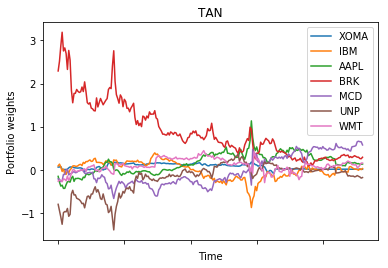

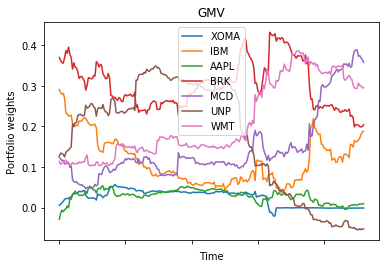

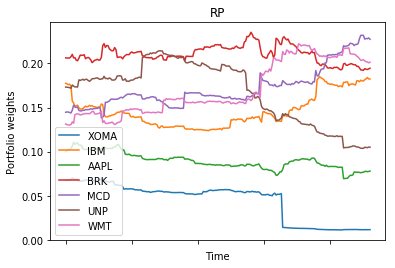

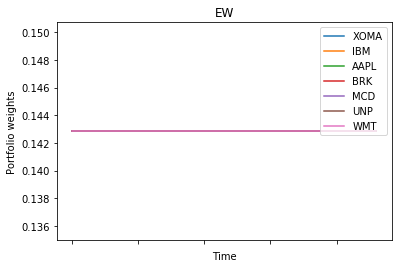

In [8]:
#plotting portfolios
asset_classes = columns
strategies = ['TAN','GMV','RP','EW']

print('\n (a) Time series of the portfolio weights:')
for i in range(len(strategies)): 
    df_w = pd.DataFrame(data=w[:,i,:],index=dates,columns=asset_classes)
    df_w.plot(title=strategies[i])
    plt.xlabel('Time')
    plt.ylabel('Portfolio weights')
    plt.legend(asset_classes, loc=0)
    plt.show()

In [9]:
#computing portfolio returns
dates_perf = ret_monthly.iloc[120:].index.get_level_values(0)

p_perf = np.zeros((len(dates_perf), 4))
for j in range(len(strategies)): 
    tmp = np.multiply(w[:-1,j,:],ret_monthly.iloc[120:]) # :-1 means except the last
    p_perf[:,j] = tmp.sum(axis=1) # sum over each lines of the matrix and p_perf = returns on each portfolios [return port for each time, strategies]
    
df_p_perf = pd.DataFrame(data=p_perf,index=dates_perf,columns=strategies)

R0 = Rf.loc[dates_perf].mean()
M = df_p_perf.mean()
E = df_p_perf.mean()-R0
S = df_p_perf.std()
SR = E/S
index = ['Mean Return', 'Mean Excess Return', 'Std. Dev.', 'Sharpe Ratio']
pStats = pd.DataFrame({index[0] : M, 
                    index[1] : E,
                    index[2] : S, 
                    index[3] : SR
                      })
pStats = pStats.T
pStats = pStats.reindex(index)

index_a = [' (ann.)']*4
index_a = [x+y for x, y in zip(index, index_a)]
pStats_a = pd.DataFrame({index_a[0] : M*12,
                    index_a[1] : E*12,
                    index_a[2] : S*np.sqrt(12),
                    index_a[3] : SR*np.sqrt(12)
                      })
pStats_a = pStats_a.T
pStats_a = pStats_a.reindex(index_a)

print('\n (b) Mean, standard deviation and Sharpe ratio of portfolio returns:')
print('\n The monthly return statistics of the strategies are:')
display(np.around(pStats,6))
print('\n The annualized return statistics of the strategies are:')
display(np.around(pStats_a,6))


 (b) Mean, standard deviation and Sharpe ratio of portfolio returns:

 The monthly return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return,0.005595,0.006764,0.010065,0.014915
Mean Excess Return,0.003775,0.004943,0.008245,0.013095
Std. Dev.,0.109831,0.045772,0.053921,0.100922
Sharpe Ratio,0.034369,0.107995,0.152907,0.129751



 The annualized return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return (ann.),0.067143,0.081164,0.120784,0.178982
Mean Excess Return (ann.),0.045297,0.059318,0.098939,0.157136
Std. Dev. (ann.),0.380466,0.158559,0.186788,0.349603
Sharpe Ratio (ann.),0.119058,0.374107,0.529684,0.449470



 (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


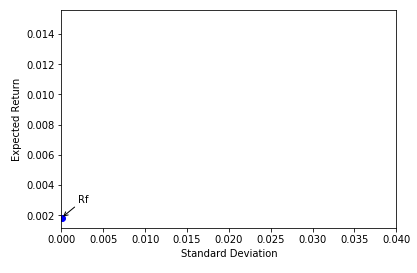

In [10]:
#MV frontiers
Mup = np.linspace(0.003,0.009,1000)
MU = ret_monthly.loc[dates_perf].mean().values
SIGMA = ret_monthly.loc[dates_perf].cov().values
INV_SIGMA = np.linalg.inv(SIGMA)


A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(S,M,'ro')
plt.plot(0.0001,R0,'bo')
plt.xlim(0, 0.04)


plt.annotate('TAN', xy=(S[0],M[0]), xytext=(S[0]-.003, M[0]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('GMV', xy=(S[1],M[1]), xytext=(S[1]-.003, M[1]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP', xy=(S[2],M[2]), xytext=(S[2]-.003, M[2]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('EW', xy=(S[3],M[3]), xytext=(S[3]-.003, M[3]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, R0), xytext=(.001+.001, R0+.001),
            arrowprops=dict(arrowstyle="->")          
            )

print('\n (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')
plt.show()


 (e) Cumulative performance of 1$ invested in December 1987:


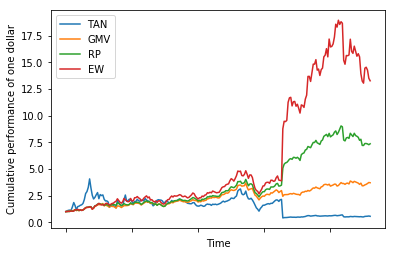

In [11]:
#total return index
dates_cumperf = ret_monthly.iloc[119:].index.get_level_values(0)
ones = np.ones((1,4))

cumperf = np.cumprod(np.concatenate((ones,1 + p_perf),axis=0),axis=0) #cumprod because when we win money we reinvest it directly
df_cumperf = pd.DataFrame(data=cumperf,index=dates_cumperf,columns=strategies)

df_cumperf.plot()
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
plt.legend(strategies, loc=0)


print('\n (e) Cumulative performance of 1$ invested in December 1987:')
plt.show()


In [12]:

labels = np.zeros(len(p_perf))
for i in range(len(p_perf)): # the goal is to define the classification of the labels for the crossentropy loss
    opt = np.argmax(p_perf[i,:])
    labels[i] = opt
print(labels.shape)
print(labels)

(230,)
[ 0.  0.  0.  1.  0.  0.  3.  3.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.
  2.  1.  3.  3.  0.  0.  3.  0.  1.  1.  3.  3.  3.  2.  2.  0.  3.  0.
  3.  3.  0.  1.  1.  0.  3.  0.  0.  1.  0.  0.  3.  1.  3.  3.  1.  0.
  1.  0.  0.  1.  3.  0.  3.  1.  3.  0.  1.  1.  0.  0.  0.  3.  2.  0.
  0.  3.  0.  3.  3.  2.  3.  0.  2.  1.  0.  1.  0.  2.  2.  0.  3.  3.
  2.  1.  2.  3.  3.  3.  0.  1.  1.  0.  3.  0.  3.  2.  3.  0.  3.  1.
  1.  1.  0.  2.  0.  1.  0.  0.  3.  3.  0.  1.  3.  0.  0.  3.  0.  0.
  1.  0.  3.  0.  0.  0.  1.  1.  3.  0.  3.  2.  3.  0.  1.  0.  1.  2.
  3.  2.  0.  0.  0.  3.  3.  0.  0.  1.  3.  2.  0.  0.  3.  3.  0.  0.
  1.  3.  3.  2.  0.  3.  3.  0.  2.  3.  3.  2.  0.  0.  0.  2.  1.  0.
  3.  0.  3.  3.  1.  3.  3.  0.  1.  1.  3.  2.  1.  2.  3.  0.  3.  1.
  3.  0.  1.  0.  3.  3.  3.  3.  1.  0.  0.  1.  2.  3.  1.  3.  3.  1.
  3.  0.  0.  2.  3.  3.  1.  0.  1.  3.  0.  1.  0.  2.]


In [13]:
# Here let's deifne the input of our model and beware to 
# take the returns of the days before the optimal month portfolio choice 
rolling_data = ret_daily.rolling(window=150,min_periods=150)

roll_daily_mean = rolling_data.mean() #rolling window => need to be defined logically with the monthly data!!
roll_daily_std = rolling_data.std() 
roll_daily_cov = rolling_data.cov()

def column_names(tickers,original =False, mean= False, std=False):
    res = []
    for t in tickers: 
        if original:
            res.append(t)
        if mean:
            res.append(t+"_mean")
        if std:
            res.append(t+"_std")
    return res

dates = ret_daily.iloc[149:-1].index.get_level_values(0)
input_price = pd.DataFrame(ret_daily.iloc[149:-1].values,columns=columns).set_index(dates)
input_mean = pd.DataFrame(roll_daily_mean[149:-1].values,columns=column_names(columns, mean= True)).set_index(dates)
input_std = pd.DataFrame(roll_daily_std[149:-1].values,columns=column_names(columns, std=True)).set_index(dates)

concat = pd.concat([input_price, input_mean, input_std], axis=1)
inputs = concat[column_names(columns, True, True, True)][3:-1]
#inputs = inputs.reshape((inputs.shape[0]/5,5, inputs.shape[1]))
print(inputs)
lstm_inputs = inputs.values.reshape((int(7785/5),5,21))
print("dataframe original shape", inputs.shape, "reshaped to ", lstm_inputs.shape )
print(lstm_inputs)

                XOMA  XOMA_mean  XOMA_std       IBM  IBM_mean   IBM_std  \
date                                                                      
08/10/1987  0.000000   0.004505  0.045720  0.014449  0.002123  0.013627   
08/11/1987  0.037037   0.004474  0.045696  0.013493  0.002185  0.013658   
08/12/1987  0.011905   0.004553  0.045699  0.008136  0.002273  0.013653   
08/13/1987  0.035294   0.003589  0.043442  0.017608  0.002425  0.013697   
08/14/1987 -0.011364   0.003061  0.043136 -0.000721  0.002522  0.013622   
08/17/1987 -0.011494   0.003090  0.043125  0.007215  0.002785  0.013324   
08/18/1987 -0.034884   0.003395  0.042688 -0.009312  0.002601  0.013300   
08/19/1987 -0.036145   0.002452  0.041979 -0.001446  0.002514  0.013283   
08/20/1987  0.062500   0.002869  0.042264  0.012310  0.002596  0.013306   
08/21/1987  0.000000   0.003187  0.042060  0.000000  0.002305  0.012870   
08/24/1987  0.070588   0.003879  0.042310 -0.000715  0.002433  0.012742   
08/25/1987 -0.065934   0.

In [14]:
#let's define the lSTM network 



    
class LSTM(nn.Module):

    def __init__(self,input_size,output_size,batch_size,num_layers,hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # The LSTM takes features as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size, hidden_size)

        # The linear layer that maps from hidden state space to output space
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

    def forward(self, input_seq):
        
        output_seq, self.hidden = self.lstm(input_seq, self.hidden)#, None)
        last_output = output_seq[-1]
        output = self.hidden2output(last_output)
        m = nn.Sigmoid() #using a sigmoid to avoid negative value of the BCELoss
        output = m(output)
        
        return output
    
    def predict(self,x):
        out = self.forward(x)
        return out
        
    

## Comment incorporer matrix dans les features ??? TODO 


In [17]:
import igraph  as ig
import louvain as lv
import networkx as net
import cairocffi as cai

ImportError: No module named 'igraph'

In [60]:
N =400
T = 2000
def take_random(returns):
    return returns.sample(N,axis=1).sample(T,axis=0)
    
matrix_returns =take_random(logreturns)
#print(matrix_returns)
correl_matrix = np.corrcoef(matrix_returns,rowvar=0)
#print(correl_matrix.shape)
from numpy import linalg as LA

eigen,vectors = LA.eig(correl_matrix)

lam_max = 1 + N/T + 2*np.sqrt(N/T)
lam_min = 1 - N/T - 2*np.sqrt(N/T)


s = np.zeros(len(eigen))
for i in range(len(eigen)):
    s[i] = 1/(N/T)/(2*np.pi) * np.sqrt((lam_max-eigen[i])*(eigen[i]-lam_min))/eigen[i]
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N = len(lambdas)
    C_clean= np.zeros((N,N))
    v_m = np.matrix(v)
    for i in range (N-1):
        if lambdas[i]>lambda_plus:
            C_clean = C_clean + lambdas[i]*np.dot(v_m[i,:].T, v_m[i,:])
    return np.abs(C_clean)

C_s = compute_C_minus_C0(eigen,vectors,lam_max)



mygraph = ig.Graph.Weighted_Adjacency(np.matrix(C_s).tolist())
myclusters=lv.find_partition(mygraph, lv.ModularityVertexPartition)
pd.DataFrame(myclusters.membership)

layout = mygraph.layout('kk')
width,height = 900,600
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
ctx = cairo.Context(surface)
ctx.scale(width,height)
ctx.rectangle(0, 0, 1, 1)
ctx.set_source_rgba(0,0,0,0)
ctx.fill()
ig.plot(mygraph,surface,bbox=(width,height),layout=layout)


NameError: name 'logreturns' is not defined